In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout,  Activation, Flatten, Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score

from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow import keras

import math
import joblib
import seaborn as sns

In [2]:
data_path=r'D:\HeartRate Classification\data\heart_disease.csv'

In [3]:
df = pd.read_csv(data_path)
df.head()

,Gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Heart_stroke
0,Male,39,postgraduate,0,0.0,0.0,no,0,0,195.0,106.0,70.0,26.97,80.0,77.0,No
1,Female,46,primaryschool,0,0.0,0.0,no,0,0,250.0,121.0,81.0,28.73,95.0,76.0,No
2,Male,48,uneducated,1,20.0,0.0,no,0,0,245.0,127.5,80.0,25.34,75.0,70.0,No
3,Female,61,graduate,1,30.0,0.0,no,1,0,225.0,150.0,95.0,28.58,65.0,103.0,yes
4,Female,46,graduate,1,23.0,0.0,no,0,0,285.0,130.0,84.0,23.10,85.0,85.0,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           4238 non-null   object 
 1   age              4238 non-null   int64  
 2   education        4133 non-null   object 
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   object 
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  Heart_stroke     4238 non-null   object 
dtypes: float64(8), int64(4), object(4)
memory usage: 529.9+ KB


# Preprocessing data

## Encode data

In [5]:
df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1})
df['education'] = df['education'].replace({'uneducated': 0, np.nan : 1,'primaryschool':2,'graduate':3,'postgraduate':4})
df['prevalentStroke'] = df['prevalentStroke'].replace({'no': 0, 'yes': 1})
df['Heart_stroke'] = df['Heart_stroke'].replace({'No': 0, 'yes': 1})

df.to_excel(r'D:\HeartRate Classification\heart_disease_test.xlsx')
df.head()

,Gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Heart_stroke
0,0,39,4,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,1,46,2,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,0,48,0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,1,61,3,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,1,46,3,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Impute missing data

In [6]:
# Dữ liệu có một số người hút thuốc mà không biết một ngày hút bao nhiêu điếu nên hàm này 
# sẽ tính trung bình số lượng điếu thuốc những người đang hút tiêu thụ trong 1 ngày 
# để bổ sung cho những người không có thông tin

mean_cigsPerDay = df[df['currentSmoker'] == 1].loc[:,'cigsPerDay'].mean()
mean_cigsPerDay =math.ceil(mean_cigsPerDay)
df['cigsPerDay'] = df['cigsPerDay'].replace({np.nan : mean_cigsPerDay})

In [7]:
nan_columns = [column for column in df.columns if df[column].isna().any()]
nan_columns

['BPMeds', 'totChol', 'BMI', 'heartRate', 'glucose']

In [8]:
def inpute_missing_data(df, col):
    age = df[df[col].isna()].loc[:,'age']
    for i in age:
        mean_value = math.ceil(df[df['age'] == i].loc[:,col].mean())
        df[col] = df[col].replace({np.nan : mean_value})

In [9]:
# Với những dòng dữ liệu còn thiếu, thì ta sẽ tính trung bình giá trị 
# còn thiếu đó với những người có cùng độ tuổi với người bị thiếu giá trị 
# và thêm vào cho người bị thiếu
for col in nan_columns:
    inpute_missing_data(df,col)

# Slip and label 

## Scaler

In [10]:
scaler = MinMaxScaler()

X = df.iloc[:, :-1]
y = df.iloc[:,-1]

## Train test slipt 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)

In [12]:
rf_classifier = RandomForestClassifier()

In [13]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [14]:
y_pred = rf_classifier.predict(X_test)

In [15]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy*100, '%')

Accuracy: 85.49528301886792 %


In [16]:
joblib.dump(rf_classifier, 'RF_chuate.pkl')

['RF_chuate.pkl']

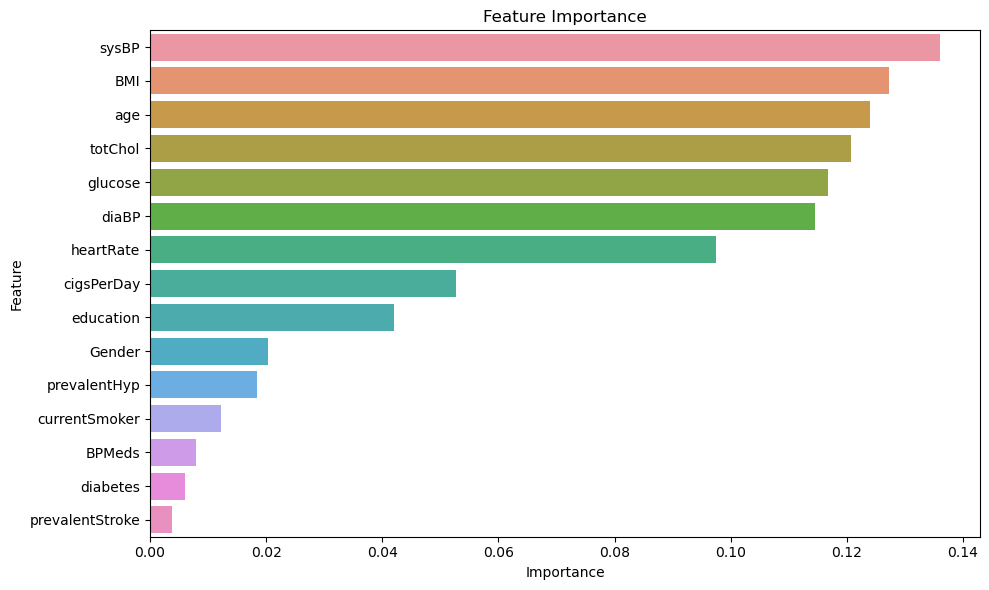

In [19]:
# Get the feature importances
importances = rf_classifier.feature_importances_
feature_names = X_train.columns

# Create a DataFrame with feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance score in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()